<a href="https://colab.research.google.com/github/Vini901/SGEMM_GPU_Kernel_Performance/blob/Supervised-Machine-Learning/Copy_of_SGEMM_GPU_Kernel_Performance_Capstone_Project_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Predicting the running times for multiplying two 2048 x 2048 matrices using a GPU OpenCL SGEMM kernel with varying parameters (using the library 'CLTune'). </u></b>

## <b> Problem Description </b>

### This data set measures the running time of a matrix-matrix product $A*B = C$, where all matrices have size 2048 x 2048, using a parameterizable SGEMM GPU kernel with 241600 possible parameter combinations. For each tested combination, 4 runs were performed and their results are reported as the 4 last columns. All times are measured in milliseconds*.

### There are 14 parameter, the first 10 are ordinal and can only take up to 4 different powers of two values, and the 4 last variables are binary. Out of 1327104 total parameter combinations, only 241600 are feasible (due to various kernel constraints). This data set contains the results for all these feasible combinations.

### The experiment was run on a desktop workstation running Ubuntu 16.04 Linux with an Intel Core i5 (3.5GHz), 16GB RAM, and a NVidia Geforce GTX 680 4GB GF580 GTX-1.5GB GPU. We use the 'gemm_fast' kernel from the automatic OpenCL kernel tuning library 'CLTune' ([Web Link]).

#### * Note: for this kind of data sets it is usually better to work with the logarithm of the running times 


## <b> Data Description </b>

### <b>Attribute Information: </b>

### Independent variables:
* ### MWG, NWG: per-matrix 2D tiling at workgroup level: {16, 32, 64, 128} (integer)
* ### KWG: inner dimension of 2D tiling at workgroup level: {16, 32} (integer)
* ### MDIMC, NDIMC: local workgroup size: {8, 16, 32} (integer)
* ### MDIMA, NDIMB: local memory shape: {8, 16, 32} (integer)
* ### KWI: kernel loop unrolling factor: {2, 8} (integer)
* ### VWM, VWN: per-matrix vector widths for loading and storing: {1, 2, 4, 8} (integer)
* ### STRM, STRN: enable stride for accessing off-chip memory within a single thread: {0, 1} (categorical)
* ### SA, SB: per-matrix manual caching of the 2D workgroup tile: {0, 1} (categorical)

### Output:
* ### Run1, Run2, Run3, Run4: performance times in milliseconds for 4 independent runs using the same parameters. They range between 13.25 and 3397.08.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/Copy of sgemm_product.csv')

In [ ]:
data.head()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms)
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0,115.26,115.87,118.55,115.80
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1,78.13,78.25,79.25,79.19
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0,79.84,80.69,80.76,80.97
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1,84.32,89.90,86.75,85.58
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0,115.13,121.98,122.73,114.81


In [ ]:
data.isna().sum()

MWG          0
NWG          0
KWG          0
MDIMC        0
NDIMC        0
MDIMA        0
NDIMB        0
KWI          0
VWM          0
VWN          0
STRM         0
STRN         0
SA           0
SB           0
Run1 (ms)    0
Run2 (ms)    0
Run3 (ms)    0
Run4 (ms)    0
dtype: int64

In [ ]:
data.shape

(241600, 18)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241600 entries, 0 to 241599
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   MWG        241600 non-null  int64  
 1   NWG        241600 non-null  int64  
 2   KWG        241600 non-null  int64  
 3   MDIMC      241600 non-null  int64  
 4   NDIMC      241600 non-null  int64  
 5   MDIMA      241600 non-null  int64  
 6   NDIMB      241600 non-null  int64  
 7   KWI        241600 non-null  int64  
 8   VWM        241600 non-null  int64  
 9   VWN        241600 non-null  int64  
 10  STRM       241600 non-null  int64  
 11  STRN       241600 non-null  int64  
 12  SA         241600 non-null  int64  
 13  SB         241600 non-null  int64  
 14  Run1 (ms)  241600 non-null  float64
 15  Run2 (ms)  241600 non-null  float64
 16  Run3 (ms)  241600 non-null  float64
 17  Run4 (ms)  241600 non-null  float64
dtypes: float64(4), int64(14)
memory usage: 33.2 MB


In [ ]:
data.duplicated().sum()

0

In [ ]:
data.iloc[:,:14].duplicated().sum()

0

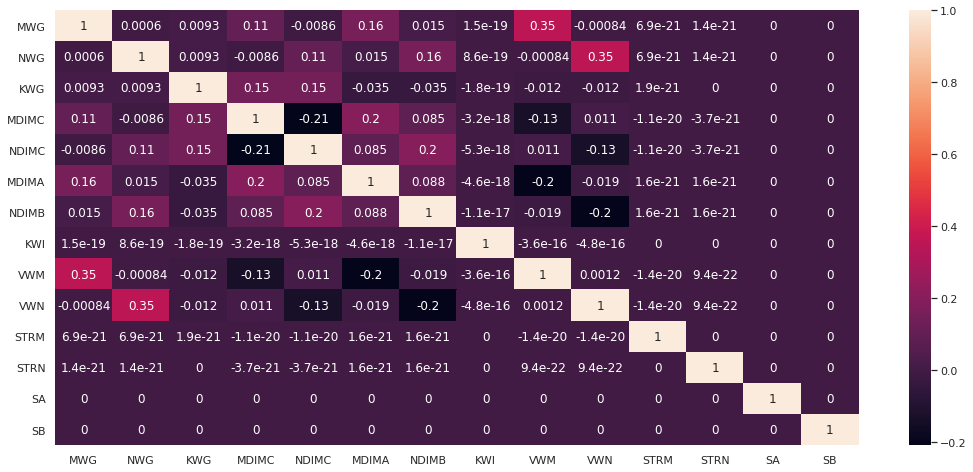

In [ ]:
plt.rcParams['figure.figsize']=(18,8)
sns.heatmap(data.iloc[:,:14].corr(),annot=True)

In [ ]:
coor=data.iloc[:,:14].corr()
coor

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB
MWG,1.000000e+00,5.999256e-04,9.295914e-03,1.057905e-01,-8.590185e-03,1.587719e-01,1.489790e-02,1.477334e-19,3.537634e-01,-8.409828e-04,6.925002e-21,1.385000e-21,0.0,0.0
NWG,5.999256e-04,1.000000e+00,9.295914e-03,-8.590185e-03,1.057905e-01,1.489790e-02,1.587719e-01,8.568535e-19,-8.409828e-04,3.537634e-01,6.925002e-21,1.385000e-21,0.0,0.0
KWG,9.295914e-03,9.295914e-03,1.000000e+00,1.483483e-01,1.483483e-01,-3.456333e-02,-3.456333e-02,-1.809508e-19,-1.198611e-02,-1.198611e-02,1.871905e-21,0.000000e+00,0.0,0.0
MDIMC,1.057905e-01,-8.590185e-03,1.483483e-01,1.000000e+00,-2.095622e-01,1.974329e-01,8.460552e-02,-3.179926e-18,-1.339114e-01,1.053121e-02,-1.120569e-20,-3.735230e-21,0.0,0.0
NDIMC,-8.590185e-03,1.057905e-01,1.483483e-01,-2.095622e-01,1.000000e+00,8.460552e-02,1.974329e-01,-5.251734e-18,1.053121e-02,-1.339114e-01,-1.120569e-20,-3.735230e-21,0.0,0.0
MDIMA,1.587719e-01,1.489790e-02,-3.456333e-02,1.974329e-01,8.460552e-02,1.000000e+00,8.809625e-02,-4.552194e-18,-2.027124e-01,-1.903229e-02,1.566122e-21,1.566122e-21,0.0,0.0
NDIMB,1.489790e-02,1.587719e-01,-3.456333e-02,8.460552e-02,1.974329e-01,8.809625e-02,1.000000e+00,-1.083339e-17,-1.903229e-02,-2.027124e-01,1.566122e-21,1.566122e-21,0.0,0.0
KWI,1.477334e-19,8.568535e-19,-1.809508e-19,-3.179926e-18,-5.251734e-18,-4.552194e-18,-1.083339e-17,1.000000e+00,-3.613975e-16,-4.814803e-16,0.000000e+00,0.000000e+00,0.0,0.0
VWM,3.537634e-01,-8.409828e-04,-1.198611e-02,-1.339114e-01,1.053121e-02,-2.027124e-01,-1.903229e-02,-3.613975e-16,1.000000e+00,1.164501e-03,-1.411219e-20,9.408125e-22,0.0,0.0
VWN,-8.409828e-04,3.537634e-01,-1.198611e-02,1.053121e-02,-1.339114e-01,-1.903229e-02,-2.027124e-01,-4.814803e-16,1.164501e-03,1.000000e+00,-1.411219e-20,9.408125e-22,0.0,0.0


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


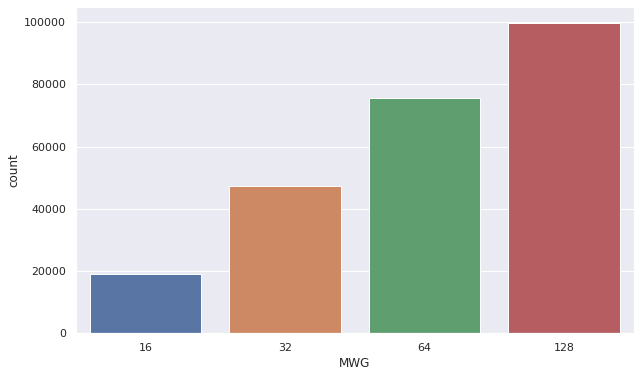

In [ ]:
plt.rcParams['figure.figsize']=(10,6)
sns.countplot(data['MWG'])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


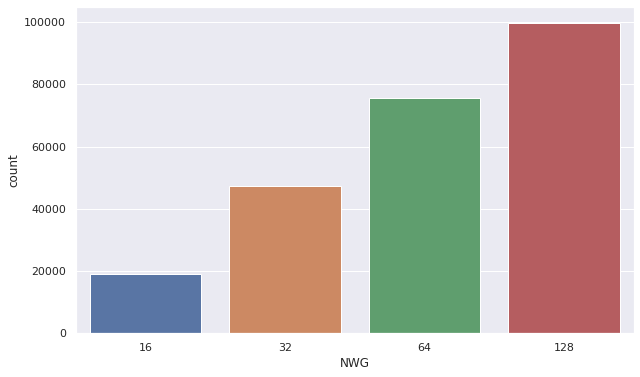

In [ ]:
sns.countplot(data['NWG'])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


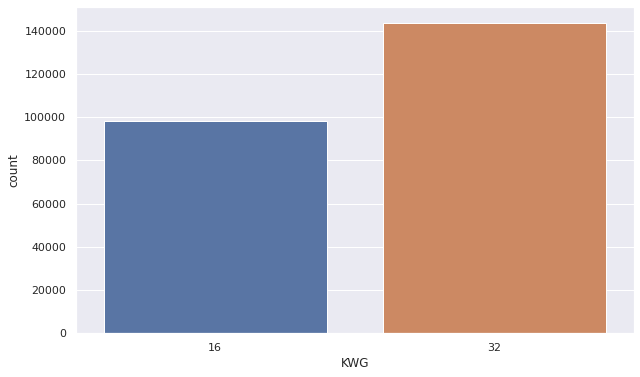

In [ ]:
sns.countplot(data['KWG'])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


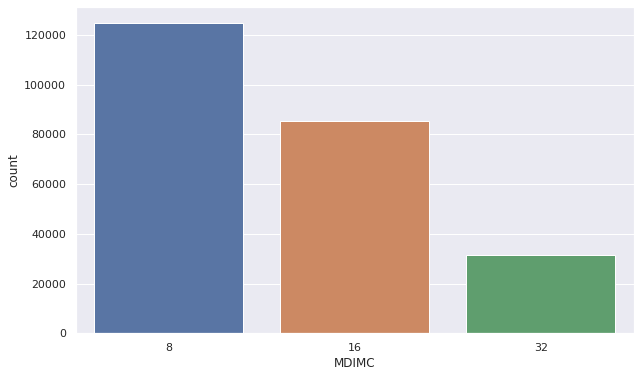

In [ ]:
sns.countplot(data['MDIMC'])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


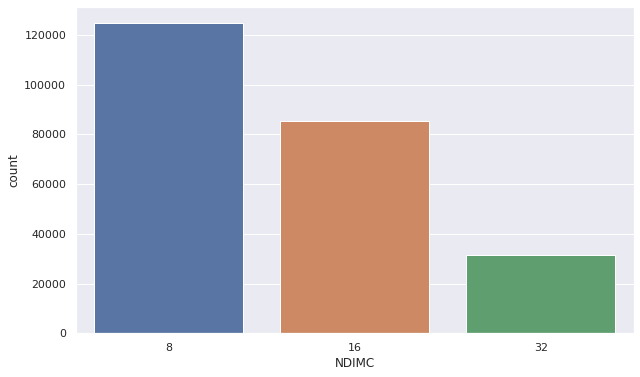

In [ ]:
sns.countplot(data['NDIMC'])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


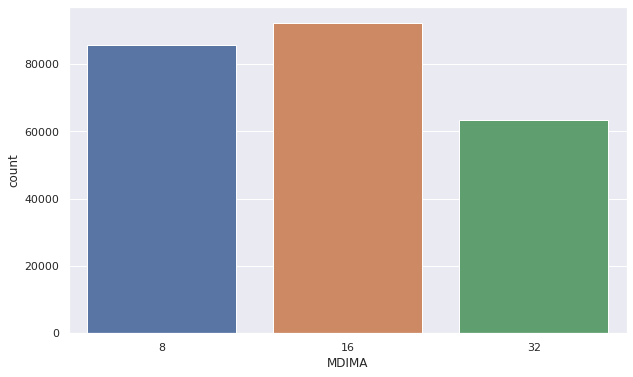

In [ ]:
sns.countplot(data['MDIMA'])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


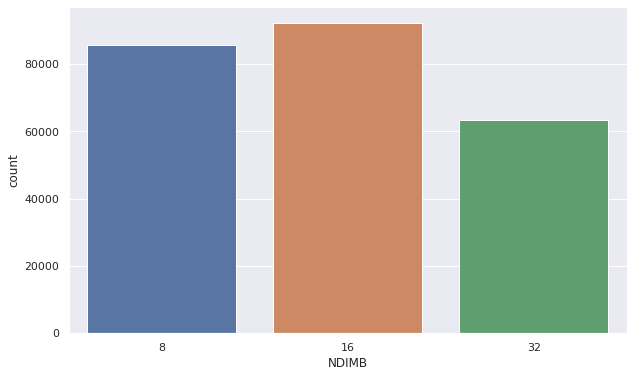

In [ ]:
sns.countplot(data['NDIMB'])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


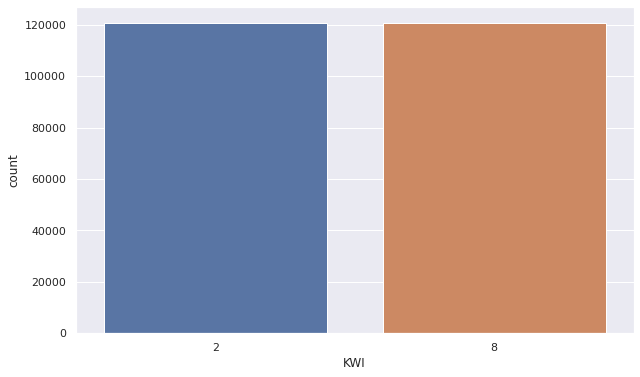

In [ ]:
sns.countplot(data['KWI'])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


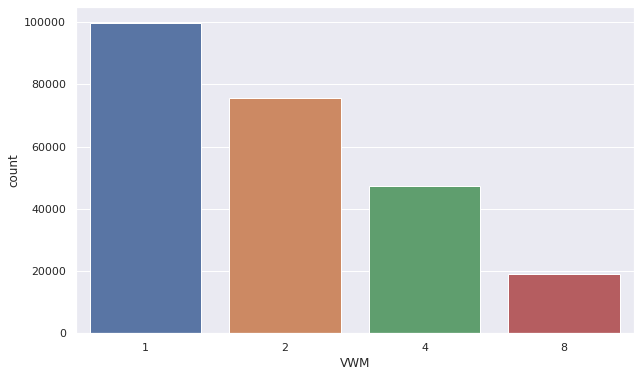

In [ ]:
sns.countplot(data['VWM'])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


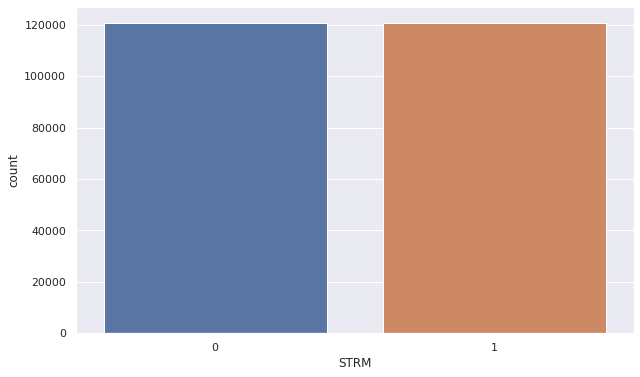

In [ ]:
sns.countplot(data['STRM'])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


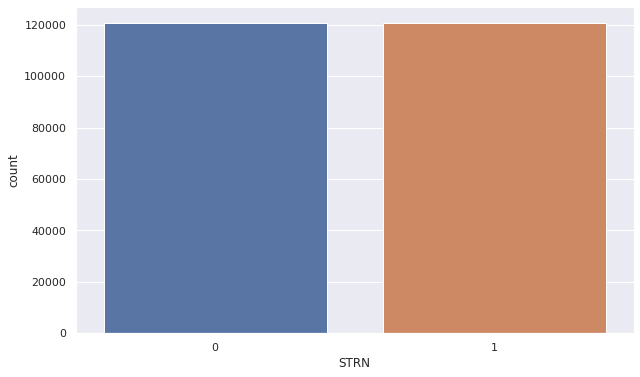

In [ ]:
sns.countplot(data['STRN'])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


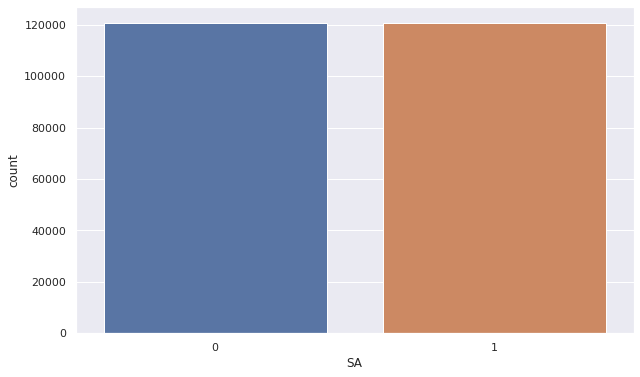

In [ ]:
sns.countplot(data['SA'])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


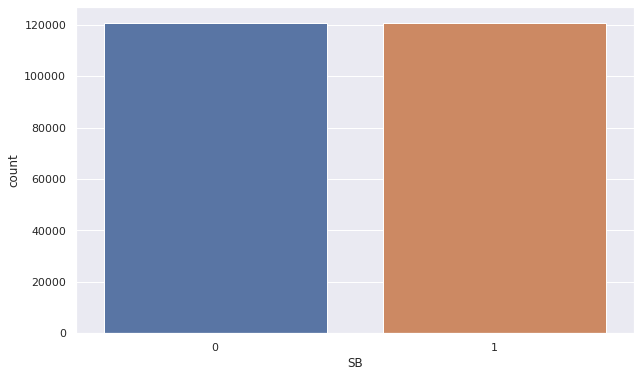

In [ ]:
sns.countplot(data['SB'])

In [ ]:
data.describe(include='all')

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms)
count,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000
mean,80.415364,80.415364,25.513113,13.935894,13.935894,17.371126,17.371126,5.000000,2.448609,2.448609,0.500000,0.500000,0.500000,0.500000,217.647852,217.579536,217.532756,217.527669
std,42.469220,42.469220,7.855619,7.873662,7.873662,9.389418,9.389418,3.000006,1.953759,1.953759,0.500001,0.500001,0.500001,0.500001,369.012422,368.677309,368.655118,368.677413
min,16.000000,16.000000,16.000000,8.000000,8.000000,8.000000,8.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,13.290000,13.250000,13.360000,13.370000
25%,32.000000,32.000000,16.000000,8.000000,8.000000,8.000000,8.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,40.660000,40.710000,40.660000,40.640000
50%,64.000000,64.000000,32.000000,8.000000,8.000000,16.000000,16.000000,5.000000,2.000000,2.000000,0.500000,0.500000,0.500000,0.500000,69.825000,69.930000,69.790000,69.820000
75%,128.000000,128.000000,32.000000,16.000000,16.000000,32.000000,32.000000,8.000000,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000,228.530000,228.310000,228.320000,228.320000
max,128.000000,128.000000,32.000000,32.000000,32.000000,32.000000,32.000000,8.000000,8.000000,8.000000,1.000000,1.000000,1.000000,1.000000,3339.630000,3375.420000,3397.080000,3361.710000


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


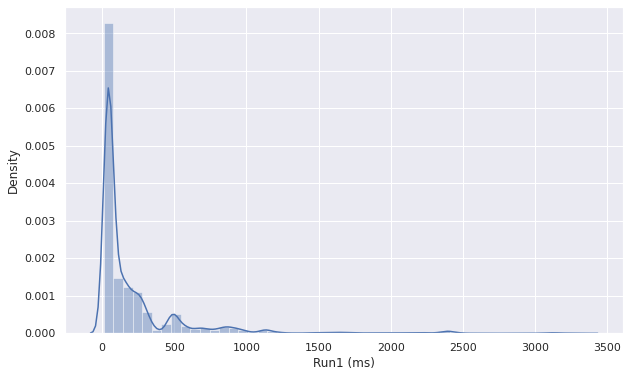

In [ ]:
sns.distplot(data['Run1 (ms)'])

In [ ]:
print('Run1')
print(data['Run1 (ms)'].skew(),data['Run1 (ms)'].kurtosis())


Run1
3.9225829941765573 19.339776229151017


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


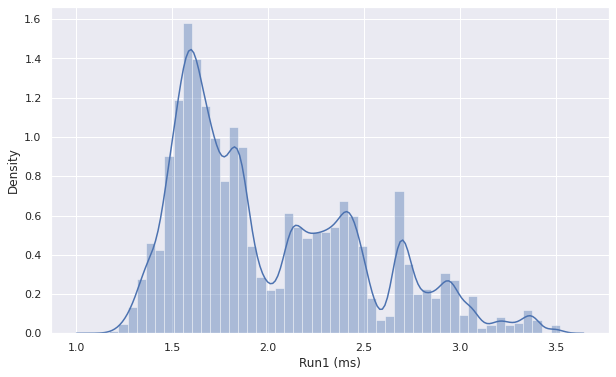

In [ ]:
sns.distplot(np.log10(data['Run1 (ms)']))

In [ ]:
print('Run1')
print(np.log10(data['Run1 (ms)']).skew(),np.log10(data['Run1 (ms)']).kurtosis())


Run1
0.7760735862932218 -0.28431038938917164


In [ ]:
data['Run1 (ms)']=np.log10(data['Run1 (ms)'])


In [ ]:
data['Run2 (ms)']=np.log10(data['Run2 (ms)'])
data['Run3 (ms)']=np.log10(data['Run3 (ms)'])
data['Run4 (ms)']=np.log10(data['Run4 (ms)'])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


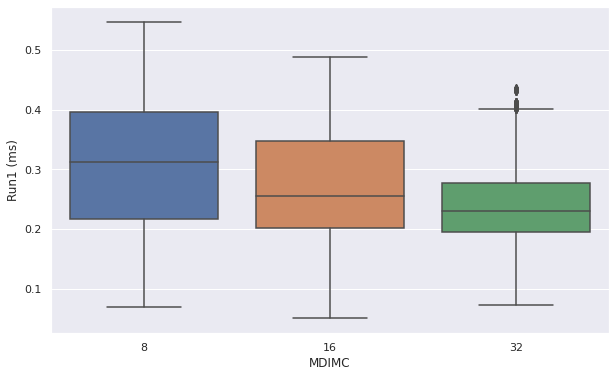

In [ ]:
sns.boxplot(data['MDIMC'],np.log10(data['Run1 (ms)']))

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


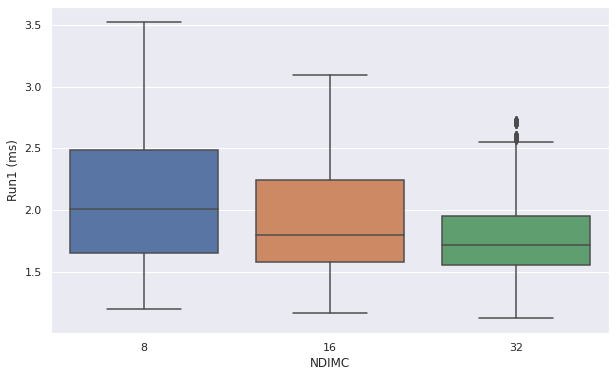

In [ ]:
sns.boxplot(data['NDIMC'],data['Run1 (ms)'])

In [ ]:
li_col=list(data.columns)
for i in li_col[:14]:
  data[i]=data[i].astype('object')

In [ ]:
x=data.drop(['Run1 (ms)','Run2 (ms)','Run3 (ms)','Run4 (ms)'],axis=1)
y1=data['Run1 (ms)']
y2=data['Run2 (ms)']
y3=data['Run3 (ms)']
y4=data['Run4 (ms)']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score,mean_absolute_error,mean_squared_error

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y1,test_size=0.25)
Regress=RandomForestRegressor()
Regress.fit(x_train,y_train)
y_pred_train=Regress.predict(x_train)
y_pred_test=Regress.predict(x_test)
print(Regress.score(x_train,y_train),Regress.score(x_test,y_test))
print(mean_absolute_error(y_train,y_pred_train),mean_absolute_error(y_test,y_pred_test))
print(mean_squared_error(y_train,y_pred_train),mean_squared_error(y_test,y_pred_test))


0.999896341568168 0.9993013613890759
0.0027857127390899733 0.007331450369819889
2.4936243527603787e-05 0.00016740305465945702


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


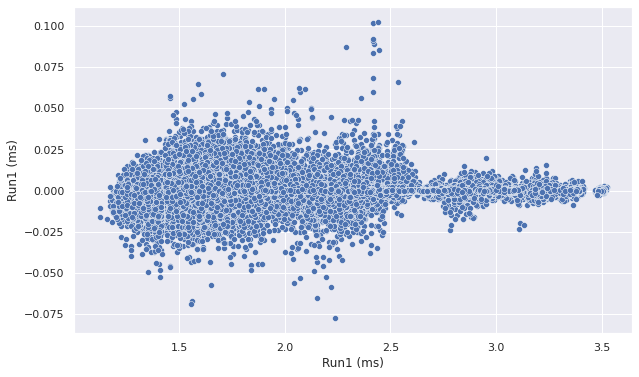

In [ ]:
sns.scatterplot(y_train,y_train-y_pred_train)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


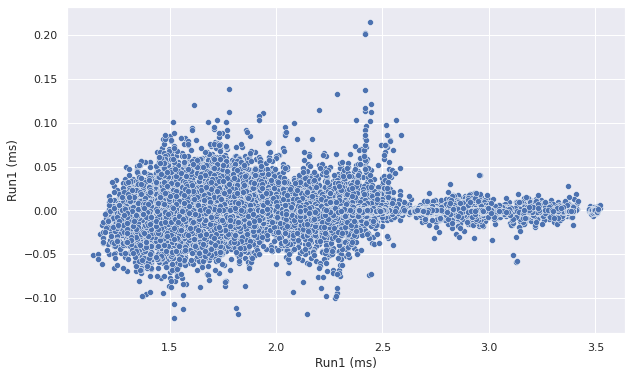

In [ ]:
sns.scatterplot(y_test,y_test-y_pred_test)


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


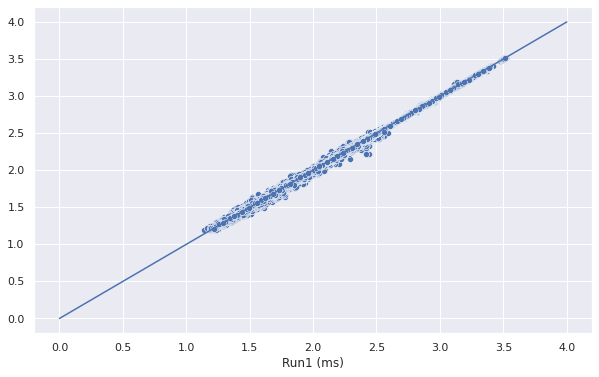

In [ ]:
sns.scatterplot(y_test, y_pred_test)
x = [i for i in range(0,5)]
y = x
sns.lineplot(x,y)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


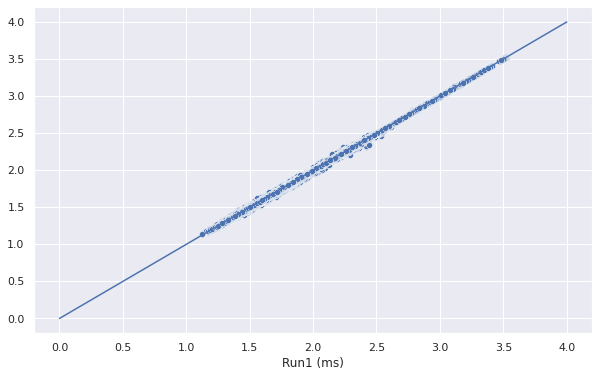

In [ ]:
sns.scatterplot(y_train, y_pred_train)
x = [i for i in range(0,5)]
y = x
sns.lineplot(x,y)

In [ ]:
import numpy as np
from sklearn import metrics
print('MSE',metrics.mean_squared_error([y_test], [y_pred_test]))
print('MAE',metrics.median_absolute_error([y_test],[y_pred_test]))
print('RMSE',np.sqrt(metrics.mean_squared_error([y_test],[y_pred_test])))
errors = abs(y_pred_test - y_test)
mape = 100 * np.mean(errors / y_test)
accuracy = 100 - mape
print('Accuracy', accuracy)

MSE 0.00016740305465945702
MAE 0.007331450369819889
RMSE 0.012938433238203807
Accuracy 99.57552674932188


In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
gfs=GridSearchCV(estimator=Regress,param_grid={'n_estimators':[60,80,100,120]},verbose=5,n_jobs=-1,cv=5)
gfs.fit(x_train,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 10.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [ ]:
gfs.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=120, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
estimated=gfs.estimator

In [ ]:
estimated.score(x_train,y_train)

0.999896341568168

In [ ]:
estimated.score(x_test,y_test)

0.9993013613890759